In [70]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
#from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
import operator
from sklearn.metrics import roc_auc_score
import pandas.io.data
from sklearn.qda import QDA
import datetime

In [199]:
df = pd.read_csv("change_df.csv")
df_temp = df.copy()
df_temp.Date = pd.to_datetime(df_temp.Date)
df = df_temp.sort('Date').set_index('Date')

In [200]:
predict=datetime.datetime(2015,1,1)
df['ud']=df['SP_Adj_Close'].shift(1)>=df['SP_Adj_Close'].shift(2)
df=df[2:]

In [266]:
def classifier(X_train, y_train, X_test, y_test, method, parameters):
    if method == 'RF':   
        return RandomForest(X_train, y_train, X_test, y_test, parameters)
    elif method == 'LinearSVM':   
        return LinearSVM(X_train, y_train, X_test, y_test,parameters)
    elif method == 'ADA':
        return ADA(X_train, y_train, X_test, y_test, parameters)
    elif method == 'GTB': 
        return GTB(X_train, y_train, X_test, y_test)
    elif method == 'QDA': 
        return QDA(X_train, y_train, X_test, y_test)

In [206]:
def CV(X_train, y_train, folds, method, parameter):
    k = int(np.floor(float(X_train.shape[0])/folds))
    acc = np.zeros(folds-1)
    for i in range(2, folds+1):
        split = float(i-1)/i
        data = X_train[:(k*i)]
        output = y_train[:(k*i)]
        index = int(np.floor(data.shape[0]*split))
        X_tr = data[:index]        
        y_tr = output[:index]
        X_te = data[(index+1):]
        y_te = output[(index+1):]        
        acc[i-2] = classifier(X_tr, y_tr, X_te, y_te, method, parameter)
    return acc.mean()  

In [222]:
def SearchGrid(X_train, y_train, folds, method, grid):
    param = grid.keys()
    finalGrid = {}
    if len(param) == 1:
        for value_0 in grid[param[0]]:
            parameters = [value_0]
            accuracy = CV(X_train, y_train, folds, method, parameters)
            finalGrid[accuracy] = parameters
        final = sorted(finalGrid.iteritems(), key=operator.itemgetter(0), reverse=True)          
        return final[0]
    elif len(param) == 2:
        for value_0 in grid[param[0]]:
            for value_1 in grid[param[1]]:
                parameters = [value_0, value_1]
                accuracy = CV(dX_train, y_train, folds,method, parameters)
                finalGrid[accuracy] = parameters
        final = sorted(finalGrid.iteritems(), key=operator.itemgetter(0), reverse=True)
        return final[0]

In [154]:
def mask(df, features,y,start_test):
    dataset=df[features+[y]].dropna()
    X=dataset[features]
    y=dataset[y]
    X_train = X[X.index < start_test]
    y_train = y[y.index < start_test]    
    X_test = X[X.index >= start_test]    
    y_test = y[y.index >= start_test]
    return X_train, y_train, X_test, y_test 

In [215]:
features=['Australia', 'Frankfurt', 'HongKong', 'London', 'NASDAQ', 'Nikkei', 'Paris', 'Treasury','DJI_YAHOO']

In [258]:
X_train, y_train, X_test, y_test=mask(df,features,'ud',predict)

In [263]:
from sklearn.svm import LinearSVC
def LinearSVM(X_train, y_train, X_test, y_test, parameters):
    clf=LinearSVC(loss="hinge",C=parameters[0])
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return accuracy

In [264]:
def RandomForest(X_train, y_train, X_test, y_test, parameters):
    clf = RandomForestClassifier(n_estimators=parameters[0],n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return accuracy

In [267]:
SearchGrid(X_train, y_train, 10, 'RF', {'n_estimators':[10,50,100]})

(0.62333081380700428, [100])

In [243]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

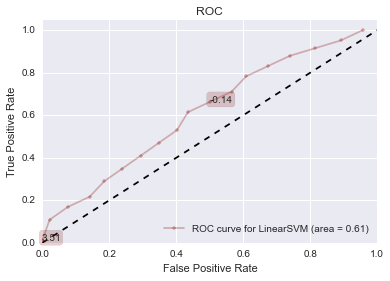

In [256]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("LinearSVM",Linear1, y_test, X_test, labe=100, skip=10,proba=False)

In [153]:
def performKNNClass(X_train, y_train, X_test, y_test):
    """
    KNN binary Classification
    """
    clf = neighbors.KNeighborsClassifier()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    #auc = roc_auc_score(y_test, clf.predict(X_test))
    return accuracy
    
def performAdaBoostClass(X_train, y_train, X_test, y_test, parameters):
    """
    Ada Boosting binary Classification
    """
    n = parameters[0]
    l =  parameters[1]
    clf = AdaBoostClassifier(n_estimators = n, learning_rate = l)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    #auc = roc_auc_score(y_test, clf.predict(X_test))
    return accuracy
    
def performGTBClass(X_train, y_train, X_test, y_test):
    """
    Gradient Tree Boosting binary Classification
    """
    clf = GradientBoostingClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    #auc = roc_auc_score(y_test, clf.predict(X_test))
    return accuracy

def performQDAClass(X_train, y_train, X_test, y_test):
    """
    Gradient Tree Boosting binary Classification
    """
    clf = QDA()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    #auc = roc_auc_score(y_test, clf.predict(X_test))
    return accuracy
